In [2]:
library(data.table)
library(dplyr)
library(Rmisc)
library(ggplot2)

# Comparisons between same- and other-race reviews regarding sentiments

## VADER

### 1. Check proportions of reviews by sentiment classes

In [3]:
rws.gh.t=fread("../data/df_processed-rws_instant_bookings.csv")

In [4]:
rws.vader=fread("../data/VADER.rws.csv")

In [5]:
rws.gh.t$gld_id=paste(rws.gh.t$guest_id,rws.gh.t$listing_id,rws.gh.t$date, sep = "-")

vd.rws=left_join(rws.gh.t, rws.vader, by="gld_id")

nrow(vd.rws[vd.rws$compound>=0.05,])/nrow(vd.rws) #-96.01% positive
nrow(vd.rws[vd.rws$compound<=-0.05,])/nrow(vd.rws) #-1.44% negative
nrow(vd.rws[vd.rws$compound>-0.05&vd.rws$compound<0.05,])/nrow(vd.rws) #-2.37% neutral

[1] 0.9600983

[1] 0.01439862

[1] 0.02370326

### 2. Compare sentiments of reviews between same- and other-race reviewers of hosts

In [6]:
list.rws=fread("../data/rws.vader.agg.host.csv")

In [7]:
ls.ins=unique(rws.gh.t[,c("listing_id","host_id")])
list.rws=left_join(ls.ins, list.rws, by="host_id")

In [8]:
t.test(compound ~ same_race, data = list.rws)


	Welch Two Sample t-test

data:  compound by same_race
t = 1.0254, df = 14468, p-value = 0.3052
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.001983246  0.006334521
sample estimates:
mean in group 0 mean in group 1 
      0.9700054       0.9678298 


In [9]:
t.test(pos ~ same_race, data = list.rws)


	Welch Two Sample t-test

data:  pos by same_race
t = 0.62989, df = 14409, p-value = 0.5288
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.001946513  0.003789926
sample estimates:
mean in group 0 mean in group 1 
      0.2904469       0.2895252 


In [10]:
t.test(neg ~ same_race, data = list.rws)


	Welch Two Sample t-test

data:  neg by same_race
t = -1.1888, df = 14405, p-value = 0.2345
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -0.0010006256  0.0002451144
sample estimates:
mean in group 0 mean in group 1 
     0.01686400      0.01724176 


#### 2.1 Visualize the mean difference

In [11]:
res=summarySE(list.rws, measurevar="compound", 
              groupvars=c("same_race"), na.rm=T)
res$same_race[which(res$same_race==1)]="Same-Race Guest"
res$same_race[which(res$same_race==0)]="Other-Race Guest"
res$same_race=as.factor(res$same_race)
dodge=position_dodge(width=0.5)

In [18]:
g = ggplot(res, aes(x=same_race , y=compound)) + 
    geom_point(position=dodge,size=2.5) +
    geom_errorbar(aes(ymin=compound-ci, ymax=compound+ci),
                  size=0.9, width=0.05, position=dodge) +
    xlab("Race of Reviewers")+ 
    ylab("Sentiment Score") + theme_bw() + theme(text=element_text(size=15))

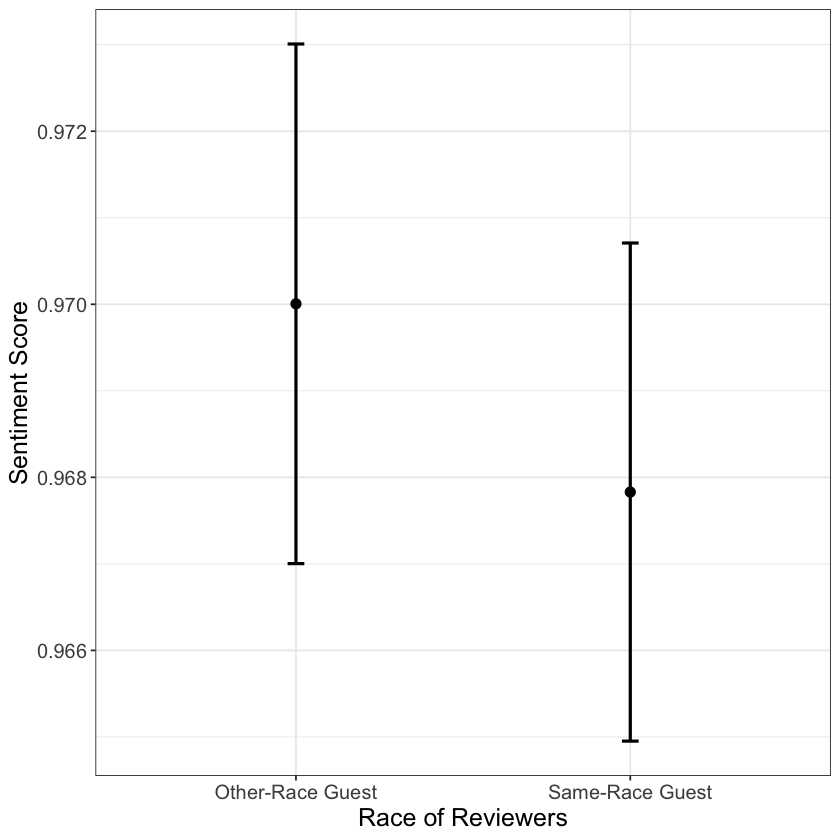

In [19]:
g

## LIWC

In [21]:
b.res=read.csv("../data/LIWC_b1000.csv")

Note regarding ***LIWC_b1000.csv***:
- HG_pair means Host-Guest pair.
- All of the data come from instant booking.
- We are interested in 6 dimensions: Certitude, Moralization, Politeness, Prosocial, Risk, and Dissatisfaction.
- Dissatisfaction should be **Want + Lack - Fulfill** considering directions of the sentiments!

In [22]:
b.res$dissat=b.res$want+b.res$lack-b.res$fulfill

vars=c("certitude","moral","polite","prosocial","risk","dissat")

res.all=data.frame()
for (x in vars) {
  n=which(colnames(b.res)==x)
  b.res[,"tmp"]=b.res[,n]
  res.tmp=summarySE(b.res, measurevar="tmp", groupvars="HG_pair")
  res.tmp$cate=x
  res.all=rbind(res.all,res.tmp)
}

In [23]:
res.all$h.ethnicity=gsub("-.*","",res.all$HG_pair)
res.all$g.ethnicity=gsub(".*-","",res.all$HG_pair)

res.all$h.ethnicity=stringr::str_to_title(res.all$h.ethnicity)
res.all$g.ethnicity=stringr::str_to_title(res.all$g.ethnicity)

res.all$h.ethnicity=factor(res.all$h.ethnicity, 
                           levels = c("White", "Asian", "Black"))
res.all$g.ethnicity=factor(res.all$g.ethnicity, 
                           levels = c("White", "Asian", "Black"))

res.all$cate=stringr::str_to_title(res.all$cate)
res.all$cate[which(res.all$cate=="Dissat")]="Dissatisfaction"

res.all$cate=factor(res.all$cate, 
                    levels = c("Certitude","Moral","Polite",
                               "Prosocial","Risk","Dissatisfaction"))
res.all$new_ci=res.all$sd*1.96

In [24]:
cc=c("#2c2d4a","#be5d05","#f1aa00")
dodge=position_dodge(width=0.5)

p1=ggplot(res.all, aes(x=g.ethnicity, y=tmp, color=h.ethnicity)) +
  geom_point(position=dodge, aes(color=h.ethnicity, group=h.ethnicity), size=2.5) +
  geom_errorbar(aes(ymin=tmp-new_ci, ymax=tmp+new_ci, color=h.ethnicity),
                size=0.9, width=0.25, position=dodge) +
  facet_wrap(~cate, scales = "free_y") +
  theme(legend.position="top", text=element_text(size=15)) +
  labs(color="Host Race") + xlab("Guest Race") + 
  ylab("Lexical Scores") +
  scale_colour_manual(values=cc) +
  theme_classic() +
  theme(legend.position="top",
        legend.justification='left',
        panel.border=element_rect(fill=NA, size=0.3),
        panel.grid.major=element_blank(),
        panel.grid.major.x=element_blank(),
        axis.text.x=element_text(angle=45, hjust=1)) +
  theme(text=element_text(size=15))

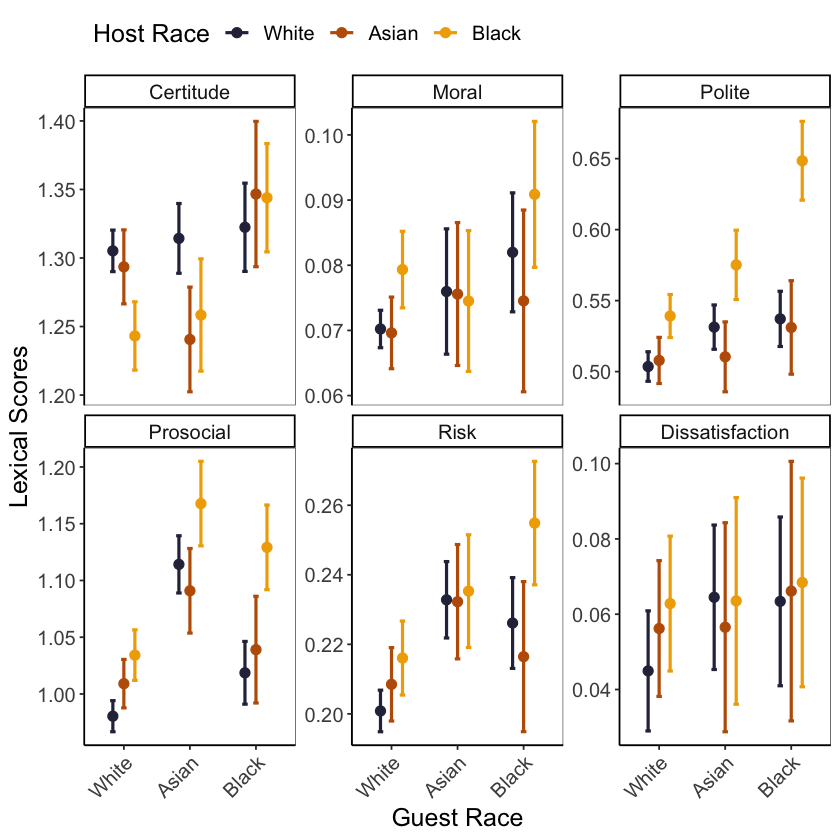

In [25]:
p1

In [26]:
p.name="../output/supp_fig_s7.pdf"
pdf(p.name, width=9.5, height=5)
plot(p1)
dev.off()

pdf 
  2